In [1]:
import pandas

pandas.set_option('display.max_rows', None, 'display.max_columns', None)
cabinet_spending_data = pandas.read_csv('../data/csv/cabinet_member_spending.csv')
yearly_spending_data = pandas.read_csv('../data/csv/Aggregate_federal_country_year_agency_.csv')

In [2]:
REPUBLICAN_PRESIDENTS = ('George W. Bush', 'Donald Trump')
DEMOCRATIC_PRESIDENTS = ('Barack Obama', )
REPUBLICAN_PARTY = 0
DEMOCRATIC_PARTY = 1

normalized_spending_data = pandas.DataFrame(columns=['department', 'party', 'domestic_spending_ratio'])
normalized_spending_data = normalized_spending_data.assign(
    department=cabinet_spending_data['Department'],
    party=cabinet_spending_data['President'].map(lambda president: REPUBLICAN_PARTY if president in REPUBLICAN_PRESIDENTS else DEMOCRATIC_PARTY),
    domestic_spending_ratio=cabinet_spending_data['domestic_spending']/(cabinet_spending_data['domestic_spending'] + cabinet_spending_data['foreign_spending']),
)

In [3]:
medians = normalized_spending_data.groupby(['department', 'party'], as_index=False)['domestic_spending_ratio'].median()

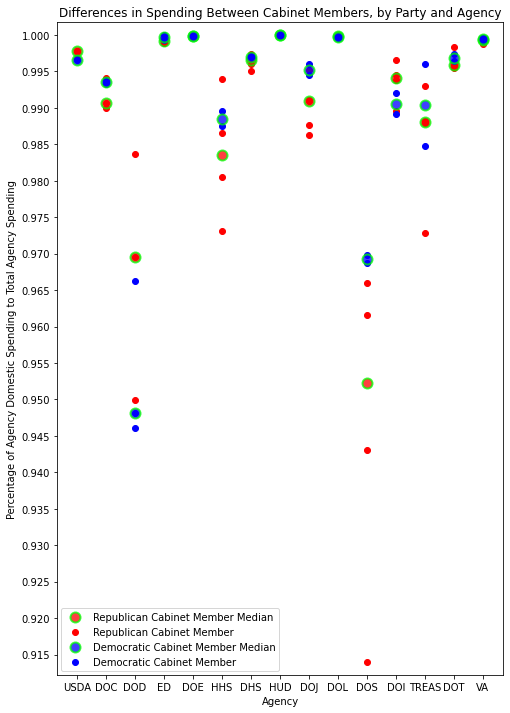

In [55]:
import matplotlib.ticker
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 12]
plot_entities = [
    {
        'party': REPUBLICAN_PARTY,
        'color': 'red',
        'label': 'Republican Cabinet Member'
    },
    {
        'party': DEMOCRATIC_PARTY,
        'color': 'blue',
        'label': 'Democratic Cabinet Member'
    },
]

plot_handles = []
for entity in plot_entities:
    party_data = normalized_spending_data[normalized_spending_data['party'] == entity['party']]
    department_handle = plt.scatter(
        [department.split("(")[1].split(")")[0] for department in party_data['department']], 
        party_data['domestic_spending_ratio'],
        c=entity['color'],
        label=entity['label']
    )

    party_medians = medians[medians['party'] == entity['party']]
    median_handle = plt.scatter(
        [department.split("(")[1].split(")")[0] for department in party_medians['department']], 
        party_medians['domestic_spending_ratio'],
        edgecolors='lime',
        facecolors=entity['color'],
        s=100,
        linewidths=2,
        alpha=0.75,
        label=entity['label'] + ' Median'
    )

    plot_handles += [median_handle, department_handle]

plt.title('Differences in Spending Between Cabinet Members, by Party and Agency')
plt.ylabel('Percentage of Agency Domestic Spending to Total Agency Spending')
plt.xlabel('Agency')
plt.legend(handles=plot_handles, bbox_to_anchor=(0.51, 0.11));
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.005))
plt.gca().margins(y=0.02)

plt.show()

## We will now calculate the difference between Republican domestic spending and Democratic domestic spending.
### A negative number indicates that Democrats spent more domestically in their department, while a positive represents the opposite.

In [5]:
all_department_medians = {}
for department in medians['department'].unique():
    all_department_medians[department] = medians[medians['department'] == department]

department_differences = pandas.DataFrame(columns=['department', 'difference', 'as_portion_of_2019_spending'])
for department, department_medians in all_department_medians.items():
    difference = (
        float(department_medians[department_medians['party'] == REPUBLICAN_PARTY]['domestic_spending_ratio'])
        - float(department_medians[department_medians['party'] == DEMOCRATIC_PARTY]['domestic_spending_ratio'])
    )

    department_2019_spending = yearly_spending_data[
        (yearly_spending_data['agency'] == department)
        & (yearly_spending_data['year'] == 2019)
    ]['sum'].sum()

    department_differences = department_differences.append(
        pandas.DataFrame({
                'department': [department],
                'difference': [difference],
                'as_portion_of_2019_spending': [department_2019_spending * difference]
            }),
    )

department_differences.reset_index(drop=True, inplace=True)

In [6]:
median = department_differences["difference"].abs().median()
mean = department_differences["difference"].abs().mean()
std = department_differences["difference"].abs().std()

print(f'Median magnitude of difference: {median * 100:0.3}%', )
print(f'Average magnitude of difference: {mean * 100:0.3}%', )
print(f'Std. Dev of magnitude of difference: {std * 100:0.3}%')
print('')

# Scale the dataframe to be percentages out of 100, rather than just decimals
scaled_differences = department_differences.copy()
scaled_differences['difference'] = scaled_differences['difference'] * 100

# Sort these scaled differences by the magnitude of their difference
scaled_differences = scaled_differences.loc[scaled_differences['difference'].abs().sort_values(ascending=False).index]

print('Differences in spending, sorted by the magnitude of difference')
scaled_differences.style.format({
    'difference': '{:0.3}%',
    'as_portion_of_2019_spending': '${:0.3e}',
    })

Median magnitude of difference: 0.126%
Average magnitude of difference: 0.399%
Std. Dev of magnitude of difference: 0.643%

Differences in spending, sorted by the magnitude of difference


,department,difference,as_portion_of_2019_spending
2,DEPARTMENT OF DEFENSE (DOD),2.14%,$6.800e+09
10,DEPARTMENT OF STATE (DOS),-1.69%,$-1.533e+08
5,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),-0.498%,$-1.368e+08
8,DEPARTMENT OF JUSTICE (DOJ),-0.429%,$-3.994e+07
11,DEPARTMENT OF THE INTERIOR (DOI),0.361%,$1.385e+07
1,DEPARTMENT OF COMMERCE (DOC),-0.291%,$-1.528e+07
12,DEPARTMENT OF THE TREASURY (TREAS),-0.234%,$-1.037e+07
0,DEPARTMENT OF AGRICULTURE (USDA),0.126%,$9.358e+06
13,DEPARTMENT OF TRANSPORTATION (DOT),-0.102%,$-6.880e+06
3,DEPARTMENT OF EDUCATION (ED),-0.0448%,$-1.347e+06
